# Behavior Tests
This notebook is used to test the behavior (not the performance) of the prototype. I.e. we are interested in the user's experience. We use the following tests:
  * iperf3 to determine the SSH's tunnel link's speed (VM to VM);
  * iperf3 to determine the Docker's virtual network link's speed (container to container on the same VM);
  * netcat to determine a baseline for file sharing between VMs (via the SSH tunnel);
  * a baseline of our crypto implementation (i.e. just the crypto, without transfering the test files);
  * file sharing via IPFS on the same VM (node to node);
  * file sharing via IPFS using two VMs (node to node);
  * and file sharing via IPFS using two VMs via a (v1/Bitswap) relay.

We store the results in .csv files, which we will then plot.

## Generate test files containing random data

In [1]:
print('Generating...')
!head -c 1048576 </dev/urandom >testfile_1_MiB.bin
!head -c 10485760 </dev/urandom >testfile_10_MiB.bin
!head -c 104857600 </dev/urandom >testfile_100_MiB.bin
!head -c 524288000 </dev/urandom >testfile_500_MiB.bin
!head -c 1073741824 </dev/urandom >testfile_1_GiB.bin
#!head -c 5368709120 </dev/urandom >testfile_5_GiB.bin
!sha256sum testfile_1_MiB.bin|cut -d' ' -f1 > testfile_1_MiB.bin.sha256sum
!sha256sum testfile_10_MiB.bin|cut -d' ' -f1 > testfile_10_MiB.bin.sha256sum
!sha256sum testfile_100_MiB.bin|cut -d' ' -f1 > testfile_100_MiB.bin.sha256sum
!sha256sum testfile_500_MiB.bin|cut -d' ' -f1 > testfile_500_MiB.bin.sha256sum
!sha256sum testfile_1_GiB.bin|cut -d' ' -f1 > testfile_1_GiB.bin.sha256sum
#!sha256sum testfile_5_GiB.bin|cut -d' ' -f1 > testfile_5_GiB.bin.sha256sum
print('Done!')

Generating...
Done!


## Obtain the link speed

### SSH tunnel
We can obtain an SSH tunnel's link speed as follows:
```
(run this command from the VM itself, so not from within this JupyterLab container)
ssh <user>@<dockerhost> -L 127.0.0.1:4444:127.0.0.1:4444 "iperf3 -s -B 127.0.0.1 -p 4444"
(launch a new terminal window)
iperf3 -c 127.0.0.1 -p 4444
```

### Docker virtual network
We can obtain the link speed between two containers on the same VM as follows:
```
(run this command from the VM itself, so not from within this JupyterLab container)
docker run -it --name iperfserver --rm --network jovian-colab_demo-net alpine sh -c "apk add iperf3 && iperf3 -s -B 0.0.0.0 -p 4444"
(launch a new terminal window)
docker run -it --name iperfclient --rm --network jovian-colab_demo-net alpine sh -c "apk add iperf3 && iperf3 -c iperfserver -p 4444"
```

## Generate netcat results
Using the generated test files above (which are available on our VM via a bind mount), we can measure the transfer time via netcat (over an SSH tunnel) using our script:
```
(run this command from the VM itself, so not from within this JupyterLab container)
./baseline_nc.sh VM-B 127.0.0.1 4445
```
Either copy the test files to the script's directory (*'./src/ipfs'*) or vice versa. Note that the script creates multiple SSH connections, so make sure credentials are set up correctly (i.e. public-key authentication is configured in ~/.ssh/config). Once the script it finished, copy/move the resulted .csv file to this JupyterLab container.

## Generate baseline crypto results
This test will encrypt/decrypt the various test files using multiple ciphers via the IPFS client Python module (without any transfer, encrypt/decrypt only). This gives us a baseline to compare the IPFS results against.

In [1]:
import jcipfsclient as ipfs
import time

# Test configuration
files = ['testfile_1_MiB.bin','testfile_10_MiB.bin','testfile_100_MiB.bin','testfile_500_MiB.bin','testfile_1_GiB.bin']
ciphers = ['plain','ChaCha20','Salsa20','AES_256_CTR']
rounds = 20

print('Processing crypto baseline...')

with open('baseline_crypto_duration_results.csv', 'w') as results:
  # .csv header
  delimiter = ';'
  results.write('File;SHA256;Cipher;Round;Time_Encrypt_Wall_Start;Time_Encrypt_Wall_Stop;Time_Decrypt_Wall_Start;Time_Decrypt_Wall_Stop;Time_Encrypt_Duration_Wall;Time_Decrypt_Duration_Wall;Time_Encrypt_Duration_Cpu;Time_Decrypt_Duration_Cpu;Time_Total_Duration_Wall;Time_Total_Duration_Cpu;Match\n')

  # Run the test
  for cipherMode in ciphers:
    for file in files:
      for round in range(0, rounds):
        print('Round ' + str(round+1) + '/' + str(rounds) + ' for file ' + str(file) + ' using cipher ' + str(cipherMode))
        chunkSize = 1024*1024*10
        base64Key = ipfs.genKey(cipherMode)
        
        # Encrypt file
        filenameEncrypted = file + '.encrypted'
        with open(file, 'rb') as fileOriginal:
          with open(filenameEncrypted, 'wb') as fileEncrypted:
            timestampEncryptWallStart = time.time()
            timestampEncryptCpuStart = time.process_time()
            for chunk in ipfs.encrypt(fileOriginal, base64Key, chunkSize, cipherMode):
              fileEncrypted.write(chunk)
            timestampEncryptCpuStop = time.process_time()
            timestampEncryptWallStop = time.time()
            timestampEncryptCpuDuration = timestampEncryptCpuStop - timestampEncryptCpuStart
            timestampEncryptWallDuration = timestampEncryptWallStop - timestampEncryptWallStart
        
        # Decrypt file
        filenameDecrypted = file + '.decrypted'
        with open(filenameEncrypted, 'rb') as fileEncrypted:
          with open(filenameDecrypted, 'wb') as fileDecrypted:
            timestampDecryptWallStart = time.time()
            timestampDecryptCpuStart = time.process_time()
            for chunk in ipfs.decrypt_from_file(fileEncrypted, base64Key, chunkSize, cipherMode):
              fileDecrypted.write(chunk)
            timestampDecryptCpuStop = time.process_time()
            timestampDecryptWallStop = time.time()
            timestampDecryptCpuDuration = timestampDecryptCpuStop - timestampDecryptCpuStart
            timestampDecryptWallDuration = timestampDecryptWallStop - timestampDecryptWallStart
      
        # Compare decrypted file to original (hash has to be the same)
        same = '?'
        hashFileDecrypted = !sha256sum $filenameDecrypted|cut -d' ' -f1
        hashFileDecrypted = hashFileDecrypted.nlstr.rstrip()
        with open(file + '.sha256sum', 'r') as fileOriginalHash:
          hashOriginal = fileOriginalHash.readlines()
          hashOriginal = hashOriginal[0].rstrip()
          if hashFileDecrypted == hashOriginal:
            same = 'yes'
          else:
            same = 'no'
            print('Warning: hash mismatch between original and decrypted (file: \'' + file + '\', cipher: ' + cipherMode + ')!')
        
        # Write results to .csv file and clean up test files / storage
        results.write(file + delimiter + hashOriginal + delimiter + cipherMode + delimiter + str(round) + delimiter + str(timestampEncryptWallStart) + delimiter + str(timestampEncryptWallStop) + delimiter + str(timestampDecryptWallStart) + delimiter + str(timestampDecryptWallStop) + delimiter + str(timestampEncryptWallDuration) + delimiter + str(timestampDecryptWallDuration) + delimiter + str(timestampEncryptCpuDuration) + delimiter + str(timestampDecryptCpuDuration) + delimiter + str(timestampEncryptWallDuration + timestampDecryptWallDuration) + delimiter + str(timestampEncryptCpuDuration + timestampDecryptCpuDuration) + delimiter + same + '\n')
        !rm $filenameEncrypted $filenameDecrypted

print('Done!')

Processing crypto baseline...
Round 1/20 for file testfile_1_MiB.bin using cipher plain
Round 2/20 for file testfile_1_MiB.bin using cipher plain
Round 3/20 for file testfile_1_MiB.bin using cipher plain
Round 4/20 for file testfile_1_MiB.bin using cipher plain
Round 5/20 for file testfile_1_MiB.bin using cipher plain
Round 6/20 for file testfile_1_MiB.bin using cipher plain
Round 7/20 for file testfile_1_MiB.bin using cipher plain
Round 8/20 for file testfile_1_MiB.bin using cipher plain
Round 9/20 for file testfile_1_MiB.bin using cipher plain
Round 10/20 for file testfile_1_MiB.bin using cipher plain
Round 11/20 for file testfile_1_MiB.bin using cipher plain
Round 12/20 for file testfile_1_MiB.bin using cipher plain
Round 13/20 for file testfile_1_MiB.bin using cipher plain
Round 14/20 for file testfile_1_MiB.bin using cipher plain
Round 15/20 for file testfile_1_MiB.bin using cipher plain
Round 16/20 for file testfile_1_MiB.bin using cipher plain
Round 17/20 for file testfile_1_MiB

## Generate inter-notebook results
This test will exchange the various test files between two JupyterLab instances using IPFS (and encryption/decryption) via the IPFS client Python module. We will launch a web server on a second JupyterLab instance that allows for automated testing (i.e. remote control of the second instance / IPFS peer node). Note that we first [have to join](./IPFS.ipynb#Join-the-IPFS-network) our IPFS nodes to the same IPFS private network.
**SECURITY WARNING:** Do not expose this web server directly to the Internet (i.e. use a secure network / tunnel / VPN)!

### Second JupyterLab instance (web server)

In [ ]:
from http.server import BaseHTTPRequestHandler, HTTPServer
from socket import getfqdn
from os import getenv
import jcipfsclient as ipfs
import json as JSON
import time

address = '0.0.0.0'
port = 4000
chunkSize = 1024*1024*10

# Local IPFS peer node address
node = getenv('IPFS_NODE')
nodeApiUrl = 'http://' + node + ':5001'

# Web server endpoints
class RequestHandler(BaseHTTPRequestHandler):
  def do_GET(self):
    self.send_response(200,)
    self.send_header("Content-type", "application/json")
    self.end_headers()
    if self.path == "/" or self.path == "/hello":
      response = {'Hello': str(getfqdn())}
    if self.path == "/hash":
      hashFileDownloaded = !sha256sum testfile.download|cut -d' ' -f1
      hashFileDownloaded = hashFileDownloaded.nlstr.rstrip()
      response = {'hashFileDownloaded': hashFileDownloaded}
    if self.path == "/garbagecollect":
      !rm testfile.download
      ipfs.collectGarbage(nodeApiUrl)
      response = {'collectGarbage': 'complete'}
    self.wfile.write(bytes(JSON.dumps(response), 'utf-8'))

  def do_POST(self):
    self.send_response(200)
    self.send_header('Content-Type', 'application/json')
    self.end_headers()
    length = int(self.headers.get('Content-Length'))
    body = self.rfile.read(length)
    body = body.decode("utf-8")
    if self.path == "/download":
      metadata = JSON.loads(body)
      timestampDownloadWallStart = time.time()
      ipfs.getFile(nodeApiUrl, metadata['cid'], 'testfile.download', metadata['base64Key'], chunkSize, metadata['cipherMode'])
      timestampDownloadWallStop = time.time()
      timestampDownloadWallDuration = timestampDownloadWallStop - timestampDownloadWallStart
      response = {'timestampDownloadWallStart': str(timestampDownloadWallStart), 'timestampDownloadWallStop': str(timestampDownloadWallStop), 'timestampDownloadWallDuration': str(timestampDownloadWallDuration)}
    self.wfile.write(bytes(JSON.dumps(response), 'utf-8'))

# Launch the web server
server = HTTPServer((address, port), RequestHandler)
print('Web server started at http://' + address + ':' + str(port))
try:
  server.serve_forever()
except KeyboardInterrupt:
  pass
finally:
  server.server_close()

print('Web server stopped')

### First JupyterLab instance (test)

In [1]:
import jcipfsclient as ipfs
import time
from os import getenv
import requests

# Test configuration
files = ['testfile_1_MiB.bin','testfile_10_MiB.bin','testfile_100_MiB.bin','testfile_500_MiB.bin','testfile_1_GiB.bin']
ciphers = ['plain','ChaCha20','Salsa20','AES_256_CTR']
rounds = 20
chunkSize = 1024*1024*10
#remoteHostUrl = 'http://notebook.jupyter-2.localhost:4000'
remoteHostUrl = 'http://notebook.jupyter-ext.localhost:4000'

# Local IPFS peer node address
#ipfsnode = getenv('IPFS_NODE')
ipfsnode = 'peer0.pnet0.orga.ipfs.localhost'
nodeApiUrl = 'http://' + ipfsnode + ':5001'

print('Processing IPFS file sharing...')

with open('inter_notebook_file_sharing_duration_results.csv', 'w') as results:
  # .csv header
  delimiter = ';'
  results.write('File;SHA256;Cipher;Round;Time_Upload_Wall_Start;Time_Upload_Wall_Stop;Time_Download_Wall_Start;Time_Download_Wall_Stop;Time_Upload_Duration_Wall;Time_Download_Duration_Wall;Time_Total_Duration_Wall;Match\n')
  
  # Run the test
  for cipherMode in ciphers:
    for file in files:
      for round in range(0, rounds):
        print('Round ' + str(round+1) + '/' + str(rounds) + ' for file ' + str(file) + ' using cipher ' + str(cipherMode))
        
        # Upload (and encrypt) file to local IPFS node
        timestampUploadWallStart = time.time()
        metadata = ipfs.addFile(nodeApiUrl=nodeApiUrl, file=file, base64Key=None, chunkSize=chunkSize, cipherMode=cipherMode)
        timestampUploadWallStop = time.time()
      
        # Instruct remote host to download (and decrypt) file from private IPFS network
        response = requests.post(remoteHostUrl + '/download', json = metadata, timeout=None)
        response = response.json()
        timestampDownloadWallStart = response['timestampDownloadWallStart']
        timestampDownloadWallStop = response['timestampDownloadWallStop']
        timestampDownloadWallDuration = response['timestampDownloadWallDuration']
        
        # Compare downloaded (plaintext) file to original (hash has to be the same)
        same = '?'
        response = requests.get(remoteHostUrl + '/hash', timeout=None)
        response = response.json()
        hashFileDownloaded = response['hashFileDownloaded']
        with open(file + '.sha256sum', 'r') as fileOriginalHash:
          hashOriginal = fileOriginalHash.readlines()
          hashOriginal = hashOriginal[0].rstrip()
          if hashFileDownloaded == hashOriginal:
            same = 'yes'
          else:
            same = 'no'
            print('Warning: hash mismatch between original and downloaded (file: \'' + file + '\', cipher: ' + cipherMode + ')!')
        
        # Write results to .csv file and clean up test files / storage
        results.write(file + delimiter + hashOriginal + delimiter + cipherMode + delimiter + str(round) + delimiter + str(timestampUploadWallStart) + delimiter + str(timestampUploadWallStop) + delimiter + timestampDownloadWallStart + delimiter + timestampDownloadWallStop  + delimiter + str(timestampUploadWallStop - timestampUploadWallStart) + delimiter + timestampDownloadWallDuration + delimiter + str(float(timestampUploadWallStop - timestampUploadWallStart) + float(timestampDownloadWallDuration)) + delimiter + same + '\n')
        ipfs.rmPin(nodeApiUrl, metadata['cid'])
        ipfs.collectGarbage(nodeApiUrl)
        requests.get(remoteHostUrl + '/garbagecollect', timeout=None)

print('Done!')

Processing IPFS file sharing...
Round 1/20 for file testfile_1_MiB.bin using cipher plain
Round 2/20 for file testfile_1_MiB.bin using cipher plain
Round 3/20 for file testfile_1_MiB.bin using cipher plain
Round 4/20 for file testfile_1_MiB.bin using cipher plain
Round 5/20 for file testfile_1_MiB.bin using cipher plain
Round 6/20 for file testfile_1_MiB.bin using cipher plain
Round 7/20 for file testfile_1_MiB.bin using cipher plain
Round 8/20 for file testfile_1_MiB.bin using cipher plain
Round 9/20 for file testfile_1_MiB.bin using cipher plain
Round 10/20 for file testfile_1_MiB.bin using cipher plain
Round 11/20 for file testfile_1_MiB.bin using cipher plain
Round 12/20 for file testfile_1_MiB.bin using cipher plain
Round 13/20 for file testfile_1_MiB.bin using cipher plain
Round 14/20 for file testfile_1_MiB.bin using cipher plain
Round 15/20 for file testfile_1_MiB.bin using cipher plain
Round 16/20 for file testfile_1_MiB.bin using cipher plain
Round 17/20 for file testfile_1_M

## Generate plots from generated .csv files
We will use the pandas and matplotlib Python libraries to visualize our measurements (both are pre-installed in our JupyterLab Docker image). The plots will be saved as .svg files.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
!mkdir plots

# Read results into memory
netcat = pd.read_csv('baseline_netcat_duration_results.csv', sep=';')
crypto = pd.read_csv('baseline_crypto_duration_results.csv', sep=';')
ipfs_same_vm = pd.read_csv('inter_notebook_file_sharing_duration_results-sameVM.csv', sep=';')
ipfs_vm_to_vm = pd.read_csv('inter_notebook_file_sharing_duration_results-vm-to-vm.csv', sep=';')
ipfs_relay = pd.read_csv('inter_notebook_file_sharing_duration_results-via-relay-between-VMs.csv', sep=';')

# Configure boxplot
x_label_order_file = ['testfile_1_MiB.bin','testfile_10_MiB.bin','testfile_100_MiB.bin','testfile_500_MiB.bin', 'testfile_1_GiB.bin']
x_label_order_cipher = ['plain','ChaCha20','Salsa20','AES_256_CTR']
figsizeFile = (11,4)
figsizeCipher = (8,4)
config = {
  'x_label_order': x_label_order_cipher,
  'fontsize': 12,
  'figsize': figsizeCipher,
  'grid': False,
  'boxprops': {
    "linestyle": "-",
    "linewidth": "1",
    "color":"black"
  },
  'whiskerprops': {
    "linestyle": "-",
    "linewidth": "1",
    "color":"black"
  },
  'medianprops': {
    "linestyle": "--",
    "linewidth": "1",
    "color":"black"
  },
  'capprops': {
    "linestyle": "-",
    "linewidth": "1",
    "color":"black"
  },
  'flierprops': {
    "linestyle": "-",
    "linewidth": "1",
    "color":"black"
  }
}

# Plot <column> per file
def create_boxplots_file(testname, df, column, config):
  print(testname + ': ' + column)
  #max = df[column].max() * 1.05
  df['File'] = pd.Categorical(df['File'], config['x_label_order'])
  plot = df.boxplot(column=column, by='File', grid=config['grid'], fontsize=config['fontsize'], figsize=config['figsize'], boxprops=config['boxprops'], whiskerprops=config['whiskerprops'], medianprops=config['medianprops'], capprops=config['capprops'], flierprops=config['flierprops'])
  plot.set_title('')
  plot.get_figure().suptitle('')
  plot.set_xlabel('File', fontsize=config['fontsize'])
  plot.set_ylabel('Total Duration (sec)', fontsize=config['fontsize'])
  plot.set_ylim(ymin=0)
  plot.get_figure().savefig('./plots/' + str(testname) + '-' + column + '.svg')
  plt.show()

# Plot <column> per cipher per file
def create_boxplots_cipher(testname, df, column, config):
  print(testname + ': ' + column)
  #max = df[column].max() * 1.05
  for file in df['File'].groupby(df['File']).unique():
    df['Cipher'] = pd.Categorical(df['Cipher'], config['x_label_order'])
    plot = df.loc[df['File'] == str(file[0])][['Cipher', column]].boxplot(column=column, by='Cipher', grid=config['grid'], fontsize=config['fontsize'], figsize=config['figsize'], boxprops=config['boxprops'], whiskerprops=config['whiskerprops'], medianprops=config['medianprops'], capprops=config['capprops'], flierprops=config['flierprops'])
    plot.set_title(str(file[0]), fontsize=config['fontsize'])
    plot.get_figure().suptitle('')
    plot.set_xlabel('Cipher', fontsize=config['fontsize'])
    plot.set_ylabel('Total Duration (sec)', fontsize=config['fontsize'])
    plot.set_ylim(ymin=0)
    plot.get_figure().savefig('./plots/' + str(testname) + '-' + column + '-' + str(file[0]) + '.svg')
    plt.show()

#netcat.head()
#crypto.head()
#ipfs_same_vm.head()
#ipfs_vm_to_vm.head()
#ipfs_relay.head()

### Plot netcat results per file

netcat-file: Time_Total_Duration_Wall


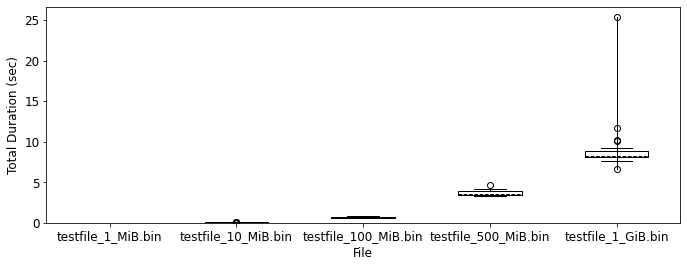

In [2]:
# Plot Time_Total_Duration_Wall
config['figsize'] = figsizeFile
config['x_label_order'] = x_label_order_file
create_boxplots_file('netcat-file', netcat, 'Time_Total_Duration_Wall', config)

### Plot baseline crypto results per file

crypto-file: Time_Total_Duration_Wall


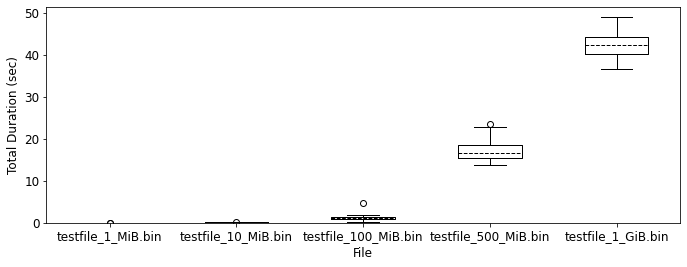

In [3]:
# Plot Time_Total_Duration_Wall
config['figsize'] = figsizeFile
config['x_label_order'] = x_label_order_file
create_boxplots_file('crypto-file', crypto, 'Time_Total_Duration_Wall', config)

crypto-file: Time_Total_Duration_Cpu


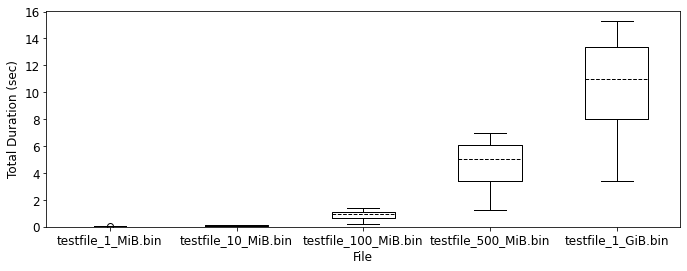

In [4]:
# Plot Time_Total_Duration_Cpu
create_boxplots_file('crypto-file', crypto, 'Time_Total_Duration_Cpu', config)

crypto-file: Time_Encrypt_Duration_Wall


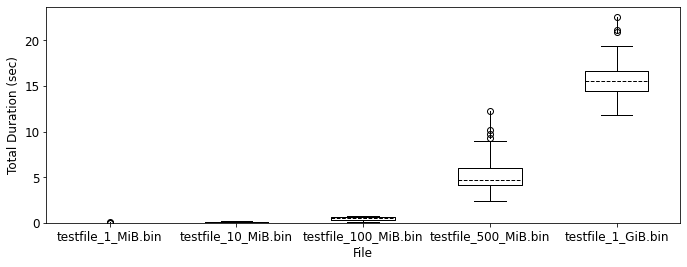

In [5]:
# Plot Time_Encrypt_Duration_Wall
create_boxplots_file('crypto-file', crypto, 'Time_Encrypt_Duration_Wall', config)

crypto-file: Time_Encrypt_Duration_Cpu


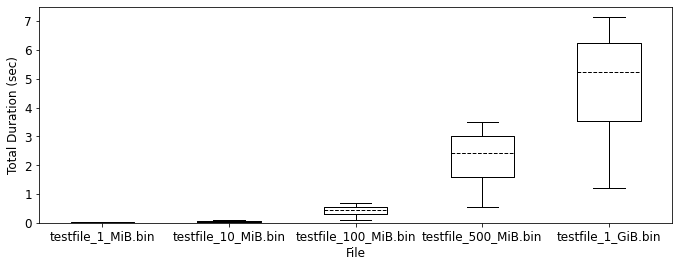

In [6]:
# Plot Time_Encrypt_Duration_Cpu
create_boxplots_file('crypto-file', crypto, 'Time_Encrypt_Duration_Cpu', config)

crypto-file: Time_Decrypt_Duration_Wall


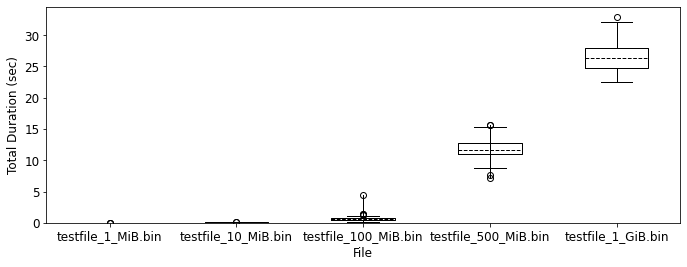

In [7]:
# Plot Time_Decrypt_Duration_Wall
create_boxplots_file('crypto-file', crypto, 'Time_Decrypt_Duration_Wall', config)

crypto-file: Time_Decrypt_Duration_Cpu


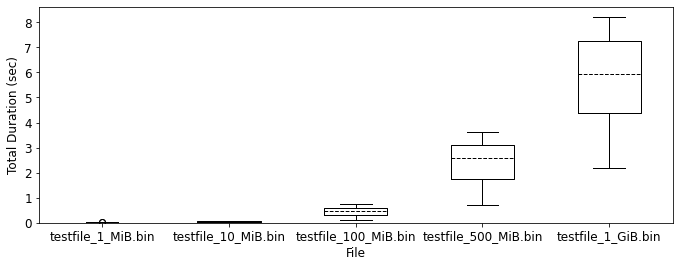

In [8]:
# Plot Time_Decrypt_Duration_Cpu
create_boxplots_file('crypto-file', crypto, 'Time_Decrypt_Duration_Cpu', config)

### Plot baseline crypto results per cipher

crypto-cipher: Time_Total_Duration_Wall


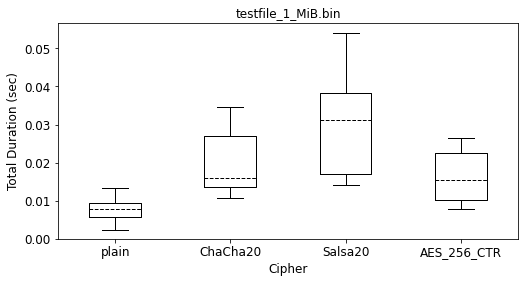

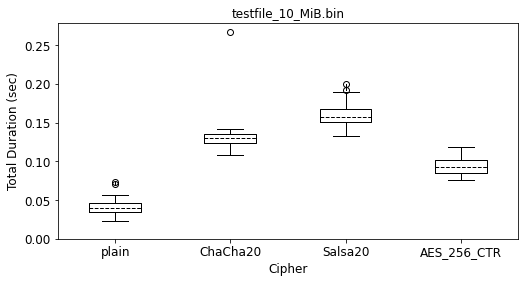

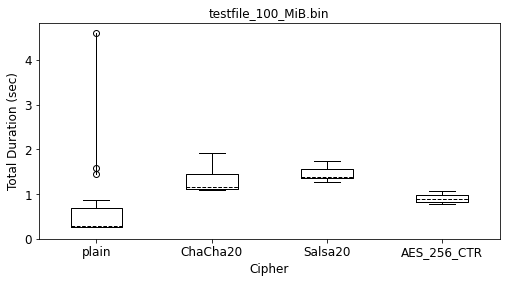

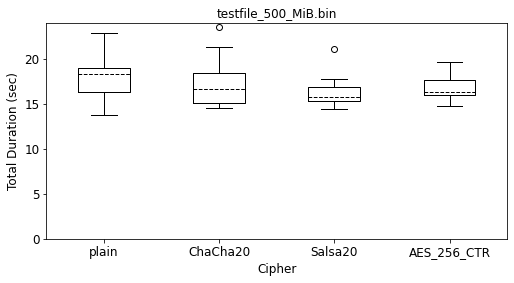

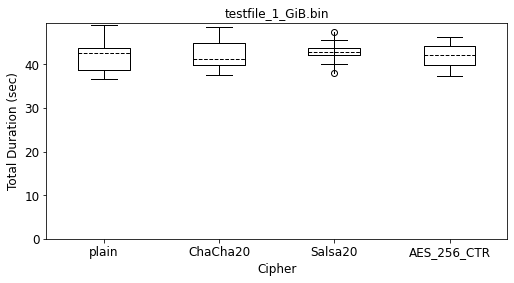

In [9]:
# Plot Time_Total_Duration_Wall
config['figsize'] = figsizeCipher
config['x_label_order'] = x_label_order_cipher
create_boxplots_cipher('crypto-cipher', crypto, 'Time_Total_Duration_Wall', config)

crypto-cipher: Time_Total_Duration_Cpu


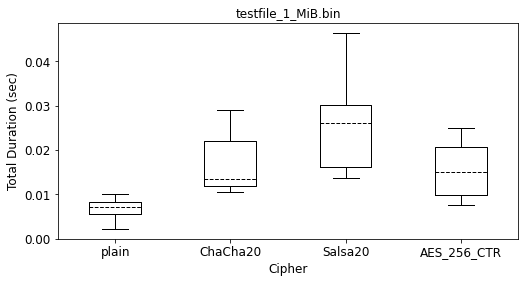

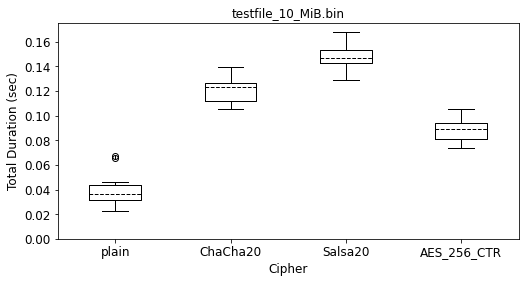

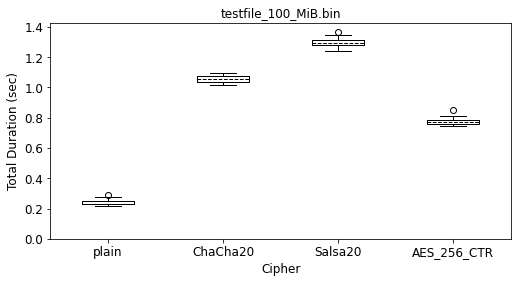

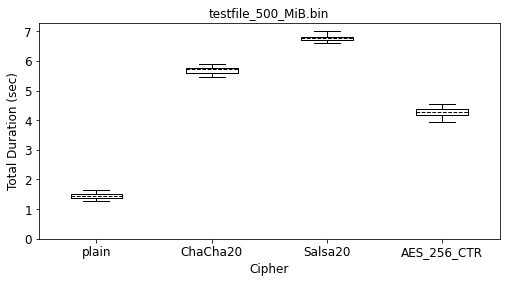

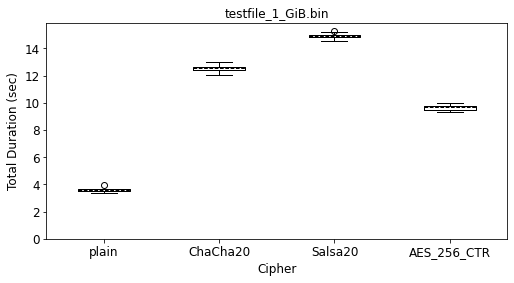

In [10]:
# Plot Time_Total_Duration_Cpu
create_boxplots_cipher('crypto-cipher', crypto, 'Time_Total_Duration_Cpu', config)

crypto-cipher: Time_Encrypt_Duration_Wall


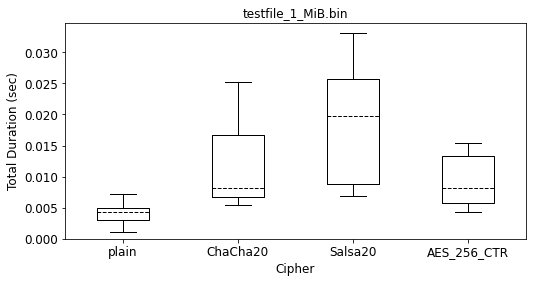

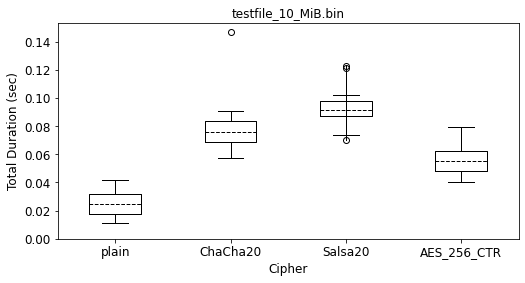

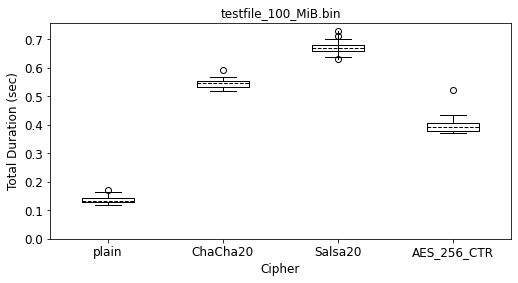

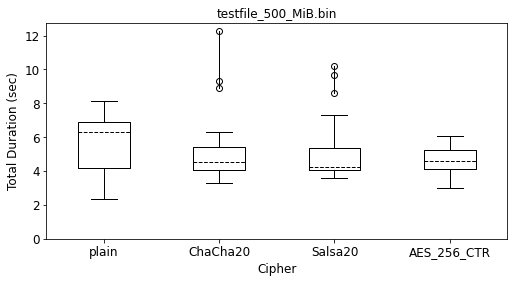

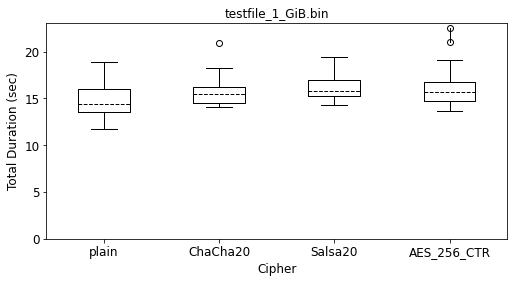

In [11]:
# Plot Time_Encrypt_Duration_Wall
create_boxplots_cipher('crypto-cipher', crypto, 'Time_Encrypt_Duration_Wall', config)

crypto-cipher: Time_Encrypt_Duration_Cpu


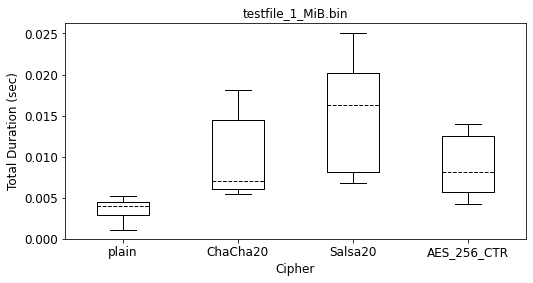

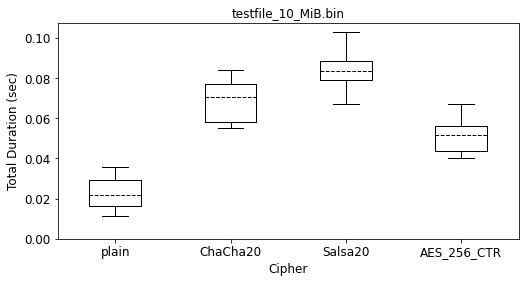

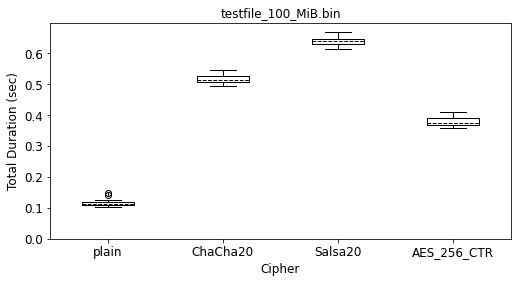

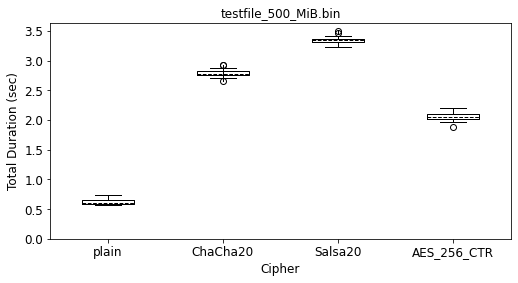

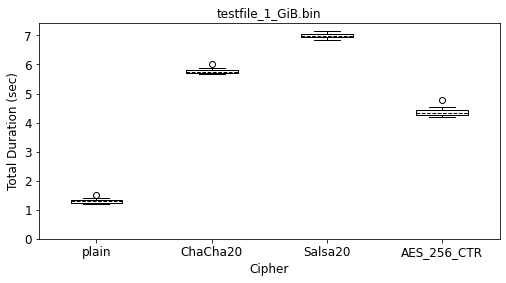

In [12]:
# Plot Time_Encrypt_Duration_Cpu
create_boxplots_cipher('crypto-cipher', crypto, 'Time_Encrypt_Duration_Cpu', config)

crypto-cipher: Time_Decrypt_Duration_Wall


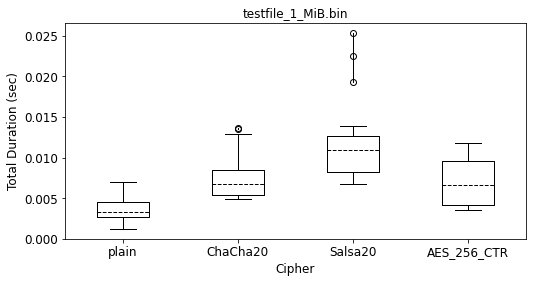

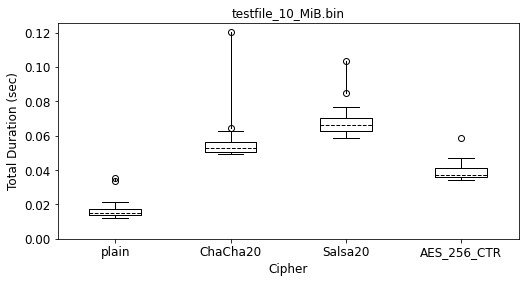

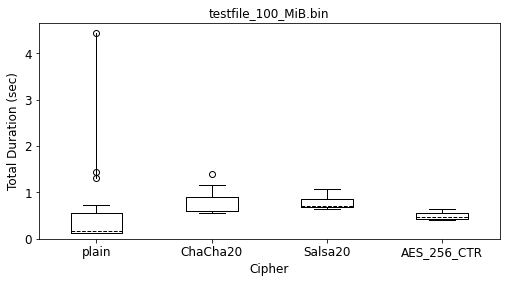

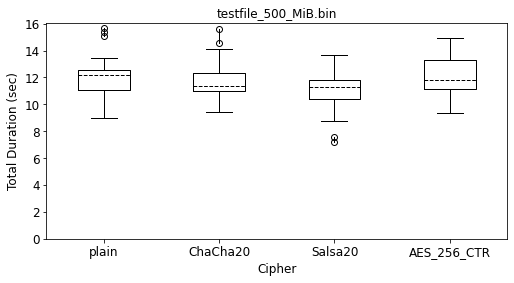

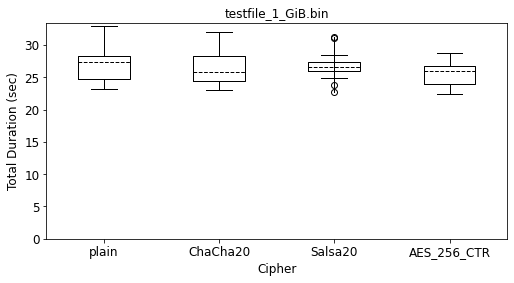

In [13]:
# Plot Time_Decrypt_Duration_Wall
create_boxplots_cipher('crypto-cipher', crypto, 'Time_Decrypt_Duration_Wall', config)

crypto-cipher: Time_Decrypt_Duration_Cpu


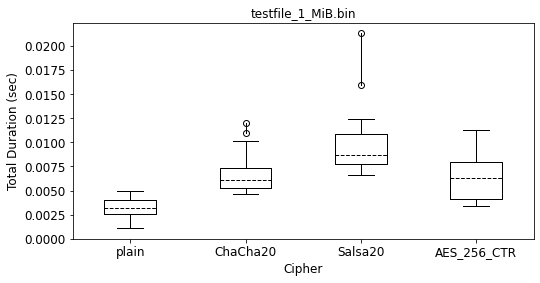

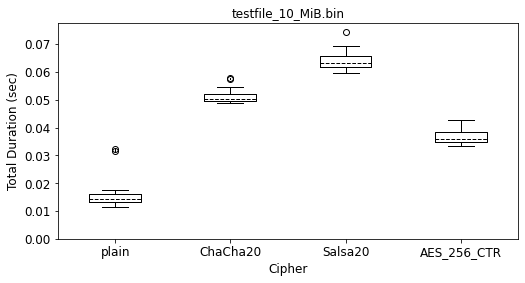

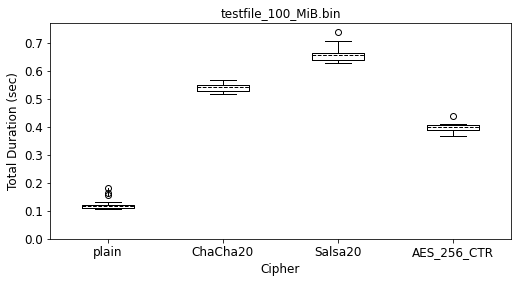

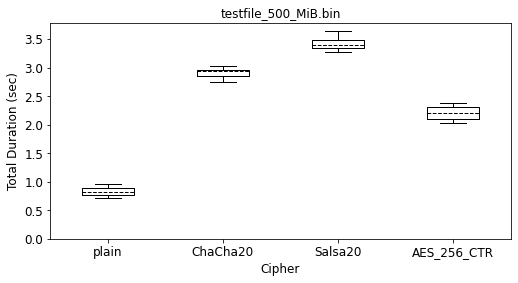

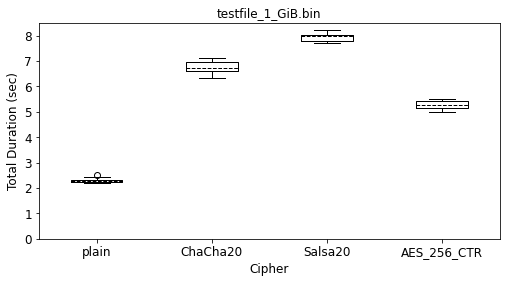

In [14]:
# Plot Time_Decrypt_Duration_Cpu
create_boxplots_cipher('crypto-cipher', crypto, 'Time_Decrypt_Duration_Cpu', config)

### Plot IPFS results per file for peer to peer on the same VM

ipfs-file-sameVM: Time_Total_Duration_Wall


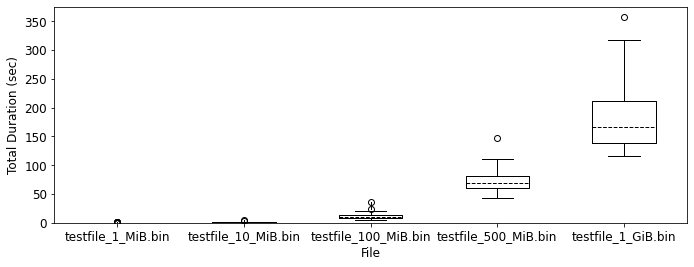

In [15]:
# Plot Time_Total_Duration_Wall
config['figsize'] = figsizeFile
config['x_label_order'] = x_label_order_file
create_boxplots_file('ipfs-file-sameVM', ipfs_same_vm, 'Time_Total_Duration_Wall', config)

ipfs-file-sameVM: Time_Upload_Duration_Wall


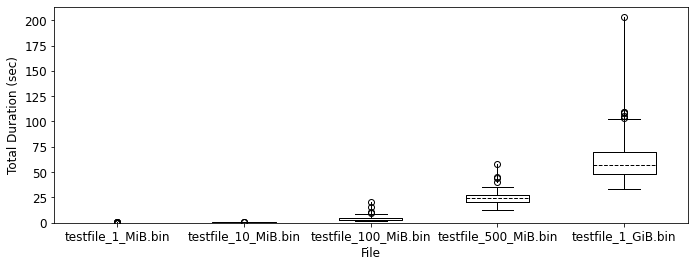

In [16]:
# Plot Time_Upload_Duration_Wall
create_boxplots_file('ipfs-file-sameVM', ipfs_same_vm, 'Time_Upload_Duration_Wall', config)

ipfs-file-sameVM: Time_Download_Duration_Wall


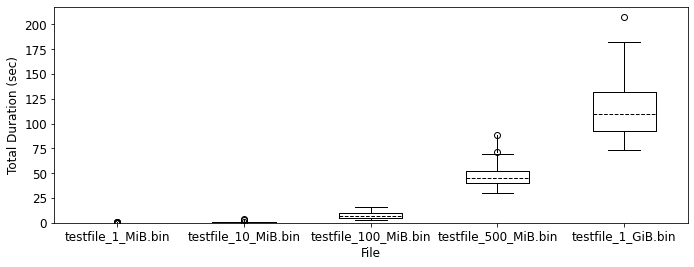

In [17]:
# Plot Time_Download_Duration_Wall
create_boxplots_file('ipfs-file-sameVM', ipfs_same_vm, 'Time_Download_Duration_Wall', config)

### Plot IPFS results per file for peer to peer on different VMs

ipfs-file-diffVM: Time_Total_Duration_Wall


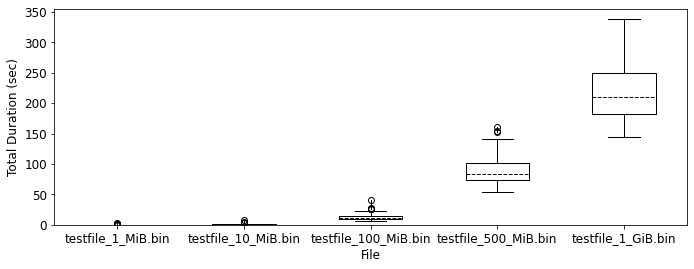

In [18]:
# Plot Time_Total_Duration_Wall
config['figsize'] = figsizeFile
config['x_label_order'] = x_label_order_file
create_boxplots_file('ipfs-file-diffVM', ipfs_vm_to_vm, 'Time_Total_Duration_Wall', config)

ipfs-file-diffVM: Time_Upload_Duration_Wall


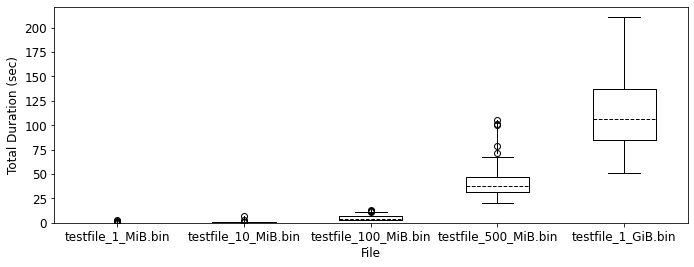

In [19]:
# Plot Time_Upload_Duration_Wall
create_boxplots_file('ipfs-file-diffVM', ipfs_vm_to_vm, 'Time_Upload_Duration_Wall', config)

ipfs-file-diffVM: Time_Download_Duration_Wall


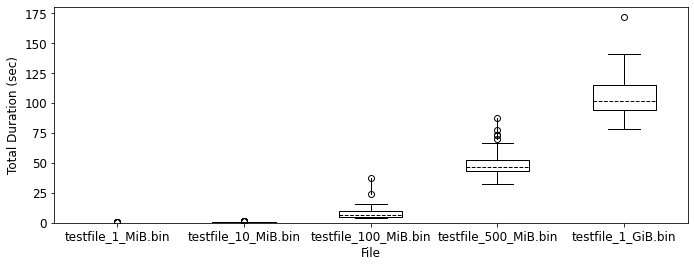

In [20]:
# Plot Time_Download_Duration_Wall
create_boxplots_file('ipfs-file-diffVM', ipfs_vm_to_vm, 'Time_Download_Duration_Wall', config)

### Plot IPFS results per file for peer to peer on different VMs via (bitswap) relay

ipfs-file-relay: Time_Total_Duration_Wall


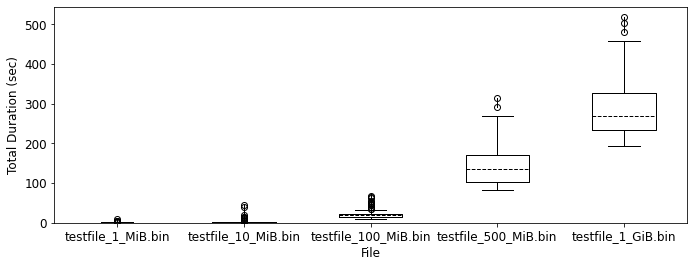

In [21]:
# Plot Time_Total_Duration_Wall
config['figsize'] = figsizeFile
config['x_label_order'] = x_label_order_file
create_boxplots_file('ipfs-file-relay', ipfs_relay, 'Time_Total_Duration_Wall', config)

ipfs-file-relay: Time_Upload_Duration_Wall


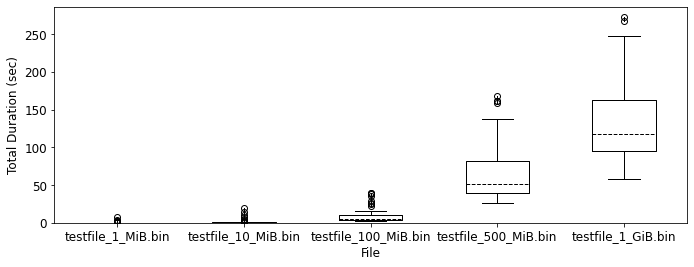

In [22]:
# Plot Time_Upload_Duration_Wall
create_boxplots_file('ipfs-file-relay', ipfs_relay, 'Time_Upload_Duration_Wall', config)

ipfs-file-relay: Time_Download_Duration_Wall


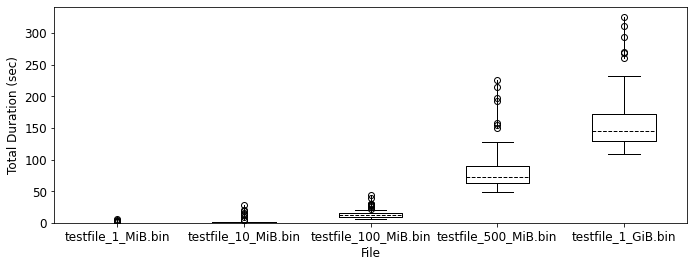

In [23]:
# Plot Time_Download_Duration_Wall
create_boxplots_file('ipfs-file-relay', ipfs_relay, 'Time_Download_Duration_Wall', config)

### Plot IPFS results per cipher for peer to peer on the same VM 

ipfs-cipher-sameVM: Time_Total_Duration_Wall


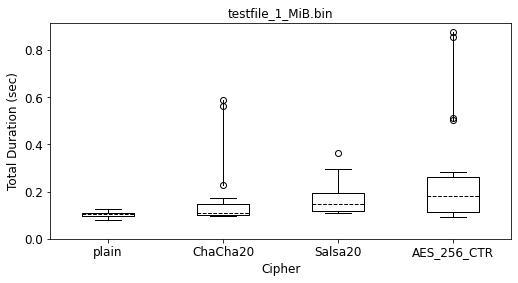

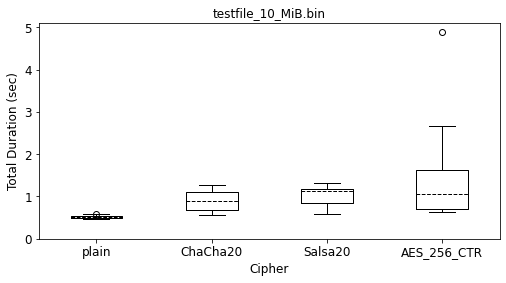

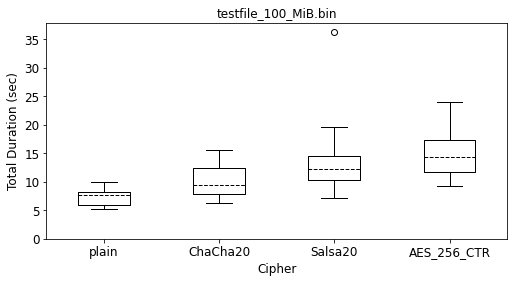

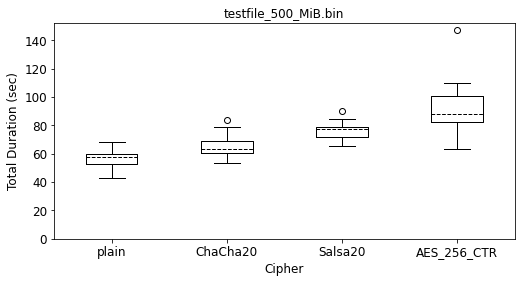

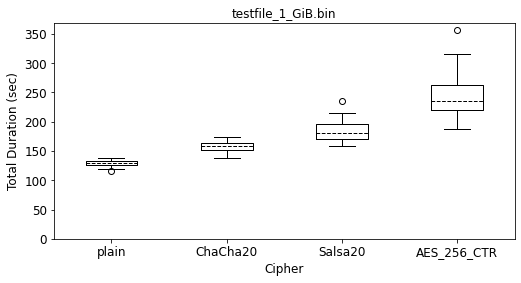

In [24]:
# Plot Time_Total_Duration_Wall
config['figsize'] = figsizeCipher
config['x_label_order'] = x_label_order_cipher
create_boxplots_cipher('ipfs-cipher-sameVM', ipfs_same_vm, 'Time_Total_Duration_Wall', config)

ipfs-cipher-sameVM: Time_Upload_Duration_Wall


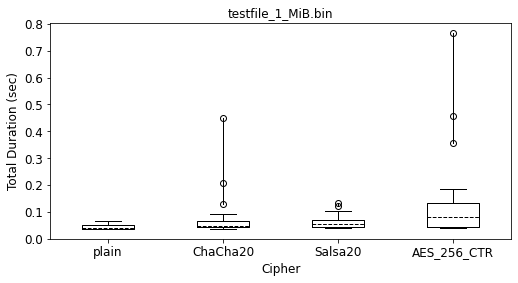

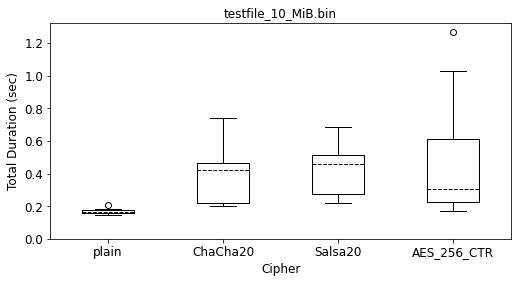

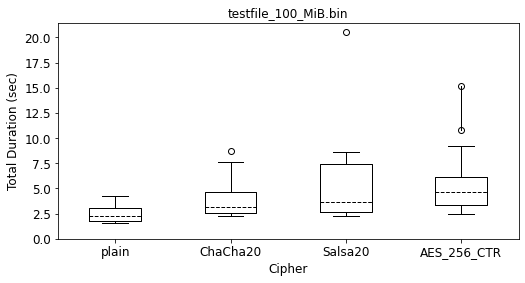

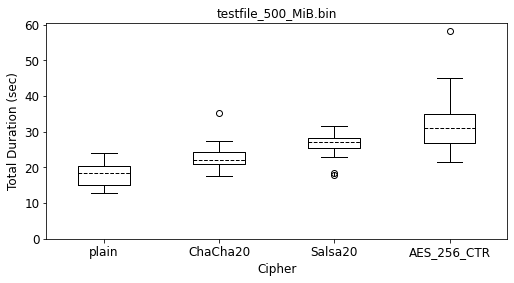

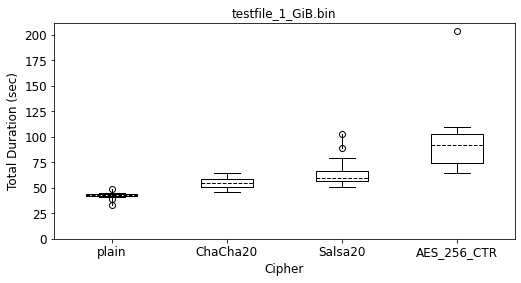

In [25]:
# Plot Time_Upload_Duration_Wall
create_boxplots_cipher('ipfs-cipher-sameVM', ipfs_same_vm, 'Time_Upload_Duration_Wall', config)

ipfs-cipher-sameVM: Time_Download_Duration_Wall


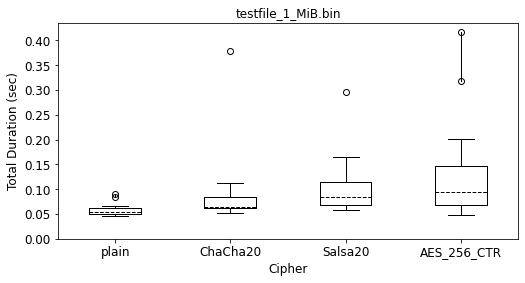

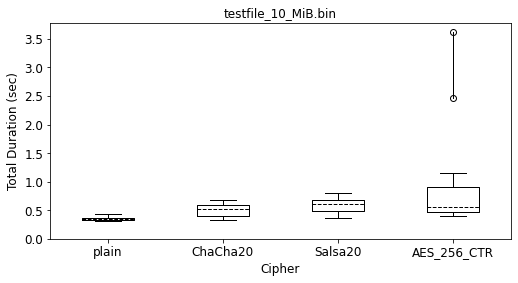

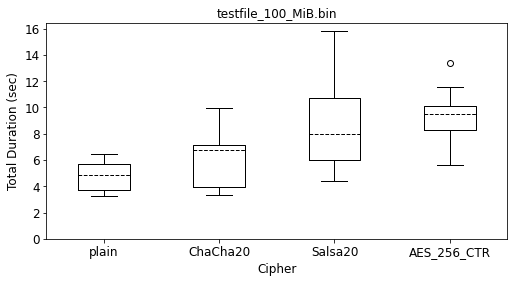

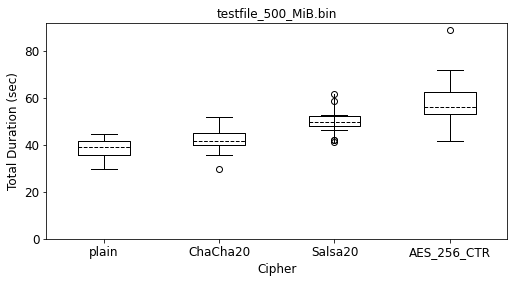

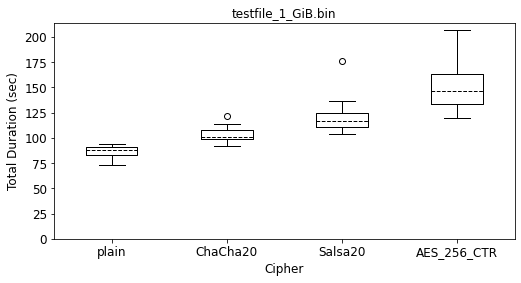

In [26]:
# Plot Time_Download_Duration_Wall
create_boxplots_cipher('ipfs-cipher-sameVM', ipfs_same_vm, 'Time_Download_Duration_Wall', config)

### Plot IPFS results per cipher for peer to peer on different VMs

ipfs-cipher-diffVM: Time_Total_Duration_Wall


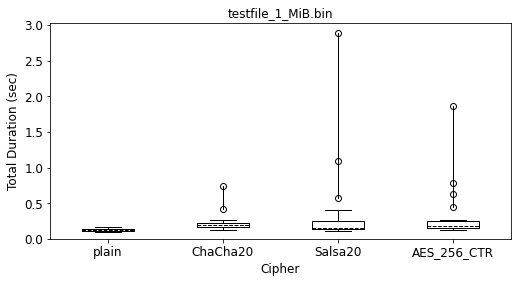

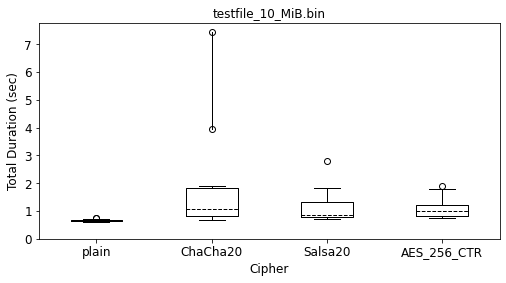

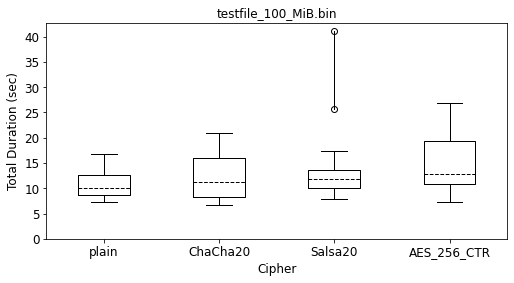

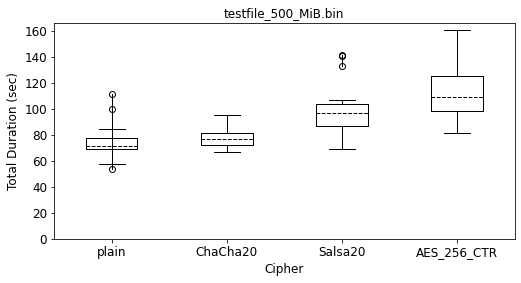

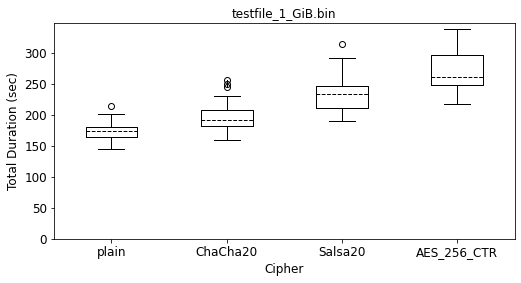

In [27]:
# Plot Time_Total_Duration_Wall
config['figsize'] = figsizeCipher
config['x_label_order'] = x_label_order_cipher
create_boxplots_cipher('ipfs-cipher-diffVM', ipfs_vm_to_vm, 'Time_Total_Duration_Wall', config)

ipfs-cipher-diffVM: Time_Upload_Duration_Wall


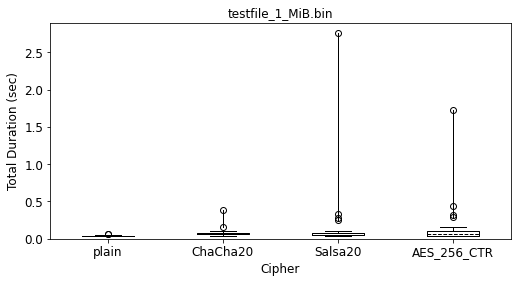

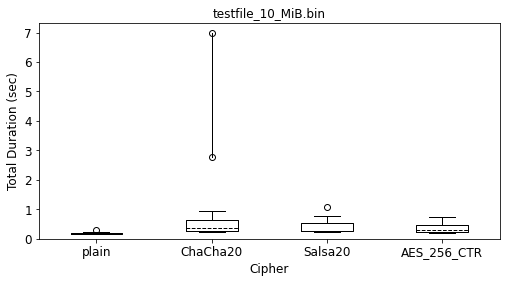

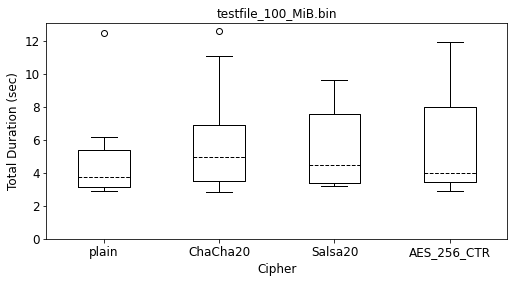

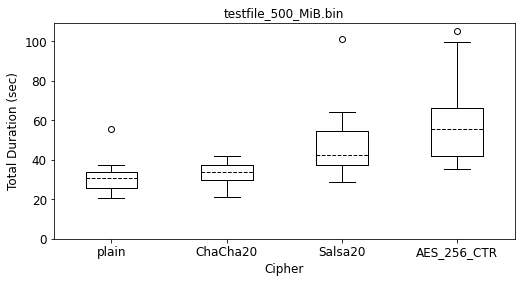

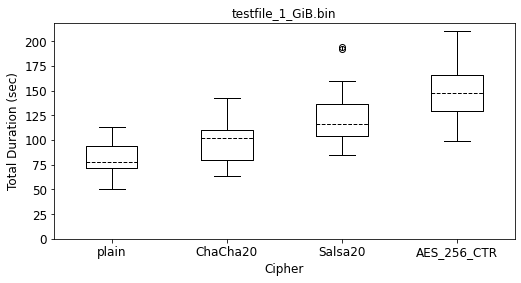

In [28]:
# Plot Time_Upload_Duration_Wall
create_boxplots_cipher('ipfs-cipher-diffVM', ipfs_vm_to_vm, 'Time_Upload_Duration_Wall', config)

ipfs-cipher-diffVM: Time_Download_Duration_Wall


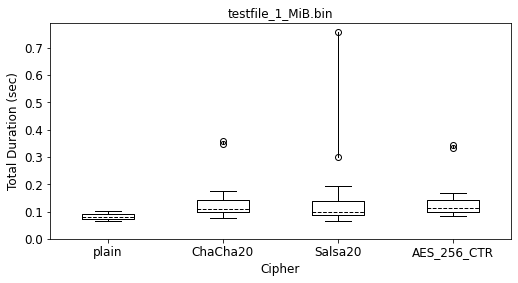

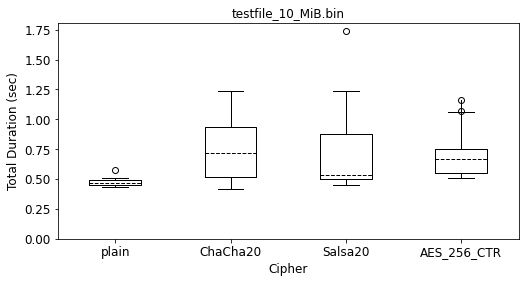

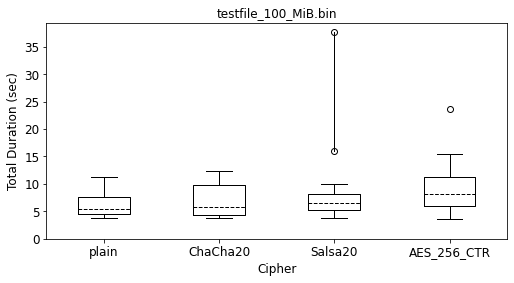

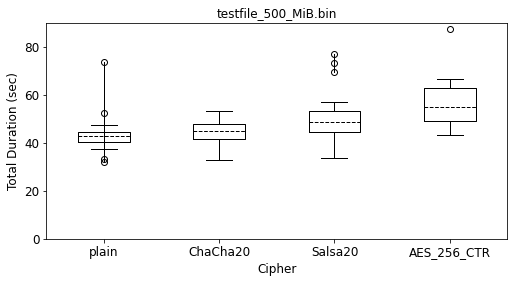

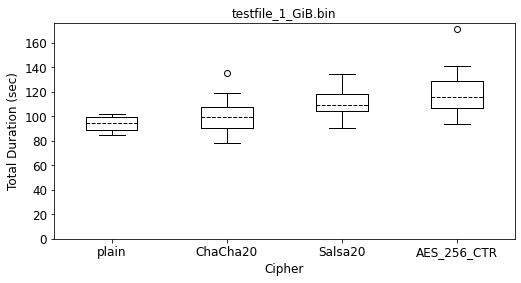

In [29]:
# Plot Time_Download_Duration_Wall
create_boxplots_cipher('ipfs-cipher-diffVM', ipfs_vm_to_vm, 'Time_Download_Duration_Wall', config)

### Plot IPFS results per cipher for peer to peer on different VMs via (bitswap) relay

ipfs-cipher-relay: Time_Total_Duration_Wall


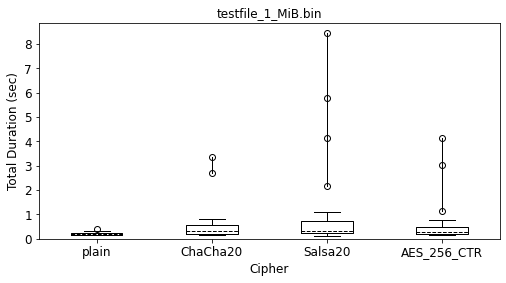

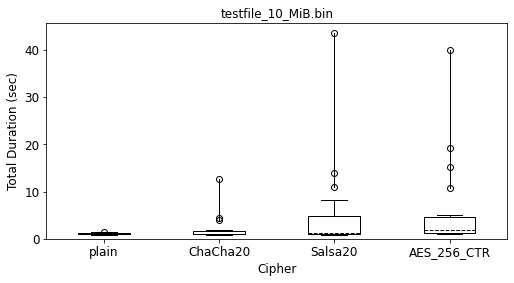

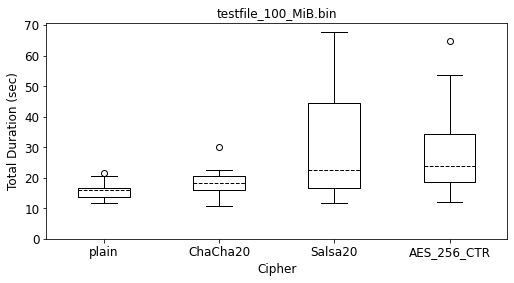

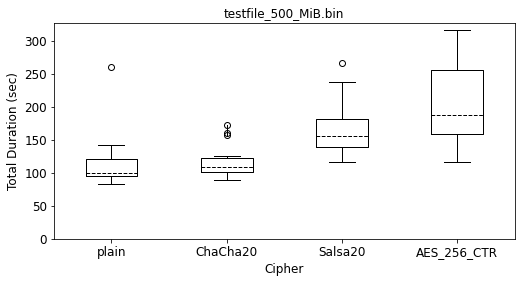

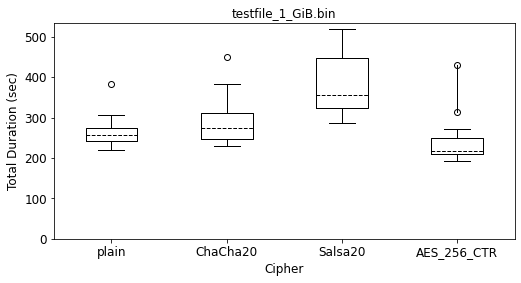

In [30]:
# Plot Time_Total_Duration_Wall
config['figsize'] = figsizeCipher
config['x_label_order'] = x_label_order_cipher
create_boxplots_cipher('ipfs-cipher-relay', ipfs_relay, 'Time_Total_Duration_Wall', config)

ipfs-cipher-relay: Time_Upload_Duration_Wall


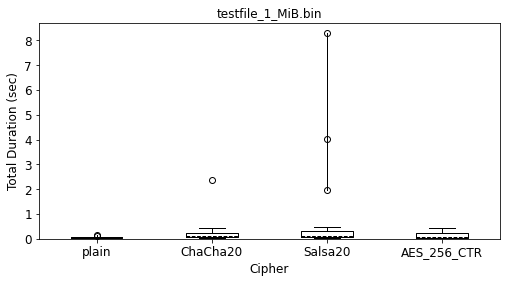

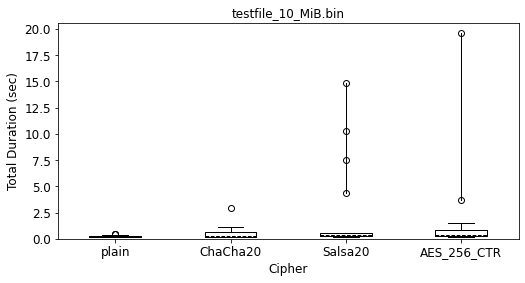

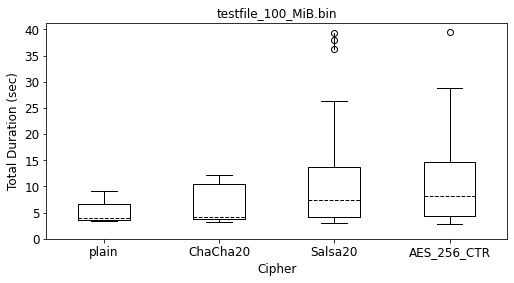

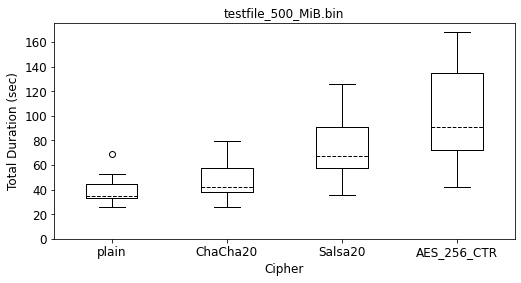

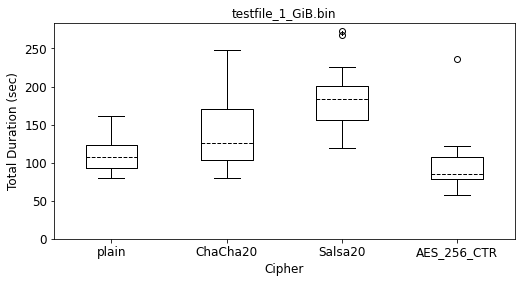

In [31]:
# Plot Time_Upload_Duration_Wall
create_boxplots_cipher('ipfs-cipher-relay', ipfs_relay, 'Time_Upload_Duration_Wall', config)

ipfs-cipher-relay: Time_Download_Duration_Wall


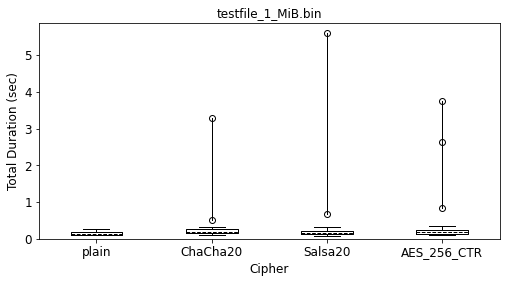

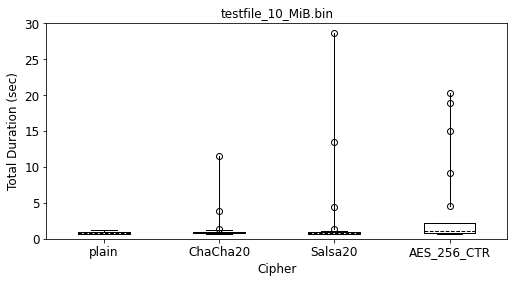

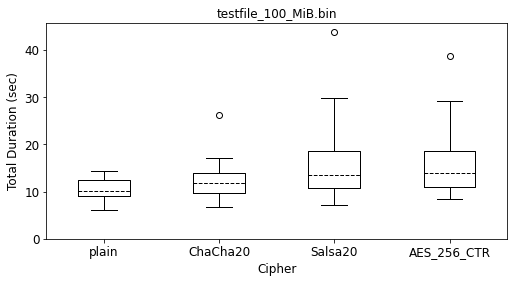

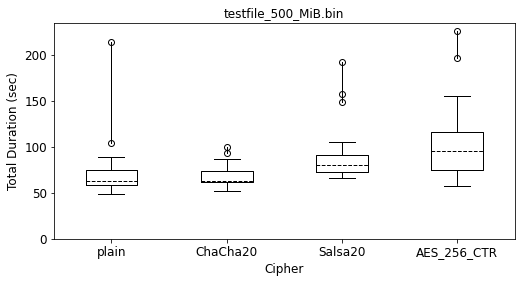

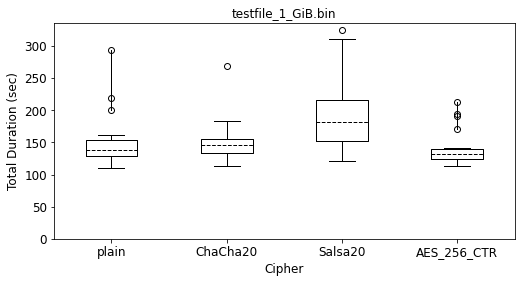

In [32]:
# Plot Time_Download_Duration_Wall
create_boxplots_cipher('ipfs-cipher-relay', ipfs_relay, 'Time_Download_Duration_Wall', config)